In [7]:
import pandas as pd
import datetime

df = pd.read_csv("movie_budget_data.csv")

df = df.rename(columns={
    'Release\r\nDate': 'release_date',
    'Title': 'movie_title',
    'Production\r\nBudget': 'production_budget',
    'Domestic\r\nGross': 'domestic_gross',
    'Worldwide\r\nGross': 'worldwide_gross'
})

df['release_date'] = pd.to_datetime(df['release_date'], format='%b %d, %Y', errors='coerce')

def currency_to_int(value):
    if isinstance(value, str):
        return int(value.replace('$', '').replace(',', ''))
    return value
df['production_budget'] = df['production_budget'].apply(currency_to_int)
df['domestic_gross'] = df['domestic_gross'].apply(currency_to_int)
df['worldwide_gross'] = df['worldwide_gross'].apply(currency_to_int)

df


,release_date,Movie,production_budget,domestic_gross,worldwide_gross
0,2023-01-13,Skinamarink,15000,2052272,2131183
1,2006-06-02,The Puffy Chair,15000,194523,195254
2,2010-04-02,Breaking Upwards,15000,115592,115592
3,2020-10-16,Sh*thouse,15000,18148,24745
4,NaT,Stories of Our Lives,15000,0,0
...,...,...,...,...,...
6620,2021-07-28,Jungle Cruise,200000000,116987516,210469803
6621,2011-06-17,Green Lantern,200000000,116601172,219535492
6622,2023-06-13,The Flash,200000000,108167507,271467507
6623,2024-11-06,Red One,200000000,97000759,185884173


In [ ]:
# remove missing data from dataset
df = df.dropna(subset=['release_date'])
df = df.dropna(subset=['release_date'])

,release_date,Movie,production_budget,domestic_gross,worldwide_gross
0,2023-01-13,Skinamarink,15000,2052272,2131183
1,2006-06-02,The Puffy Chair,15000,194523,195254
2,2010-04-02,Breaking Upwards,15000,115592,115592
3,2020-10-16,Sh*thouse,15000,18148,24745
5,1997-04-11,Pink Flamingos,12000,413802,413802
...,...,...,...,...,...
6620,2021-07-28,Jungle Cruise,200000000,116987516,210469803
6621,2011-06-17,Green Lantern,200000000,116601172,219535492
6622,2023-06-13,The Flash,200000000,108167507,271467507
6623,2024-11-06,Red One,200000000,97000759,185884173


In [17]:
# Calculate the average return on investment
average_roi = (df['worldwide_gross'] / df['production_budget']).mean()
print(f'Average ROI (Worldwide Gross / Budget): {average_roi:.2f}')

# Find movies with highest ROI
df['roi'] = df['worldwide_gross'] / df['production_budget']
top_roi_movies = df.sort_values('roi', ascending=False).head(10)
print("\nTop 10 Movies by ROI:")
print(top_roi_movies[['Movie', 'production_budget', 'worldwide_gross', 'roi']])

# Find movies with highest absolute profit
df['profit'] = df['worldwide_gross'] - df['production_budget']
top_profit_movies = df.sort_values('profit', ascending=False).head(10)
print("\nTop 10 Movies by Absolute Profit:")
print(top_profit_movies[['Movie', 'production_budget', 'worldwide_gross', 'profit']])

Average ROI (Worldwide Gross / Budget): 4.63

Top 10 Movies by ROI:
                        Movie  production_budget  worldwide_gross          roi
110               Deep Throat              25000         45000000  1800.000000
418       Paranormal Activity             450000        194183034   431.517853
30                The Gallows             100000         42964410   429.644100
325   The Blair Witch Project             600000        248300000   413.833333
65              Super Size Me              65000         22233808   342.058585
52                     Scoob!              90000         28748685   319.429833
457                     Bambi             858000        268000000   312.354312
26   Night of the Living Dead             114000         30087064   263.921614
706                     Rocky            1000000        225000000   225.000000
271                 Halloween             325000         70274000   216.227692

Top 10 Movies by Absolute Profit:
                            

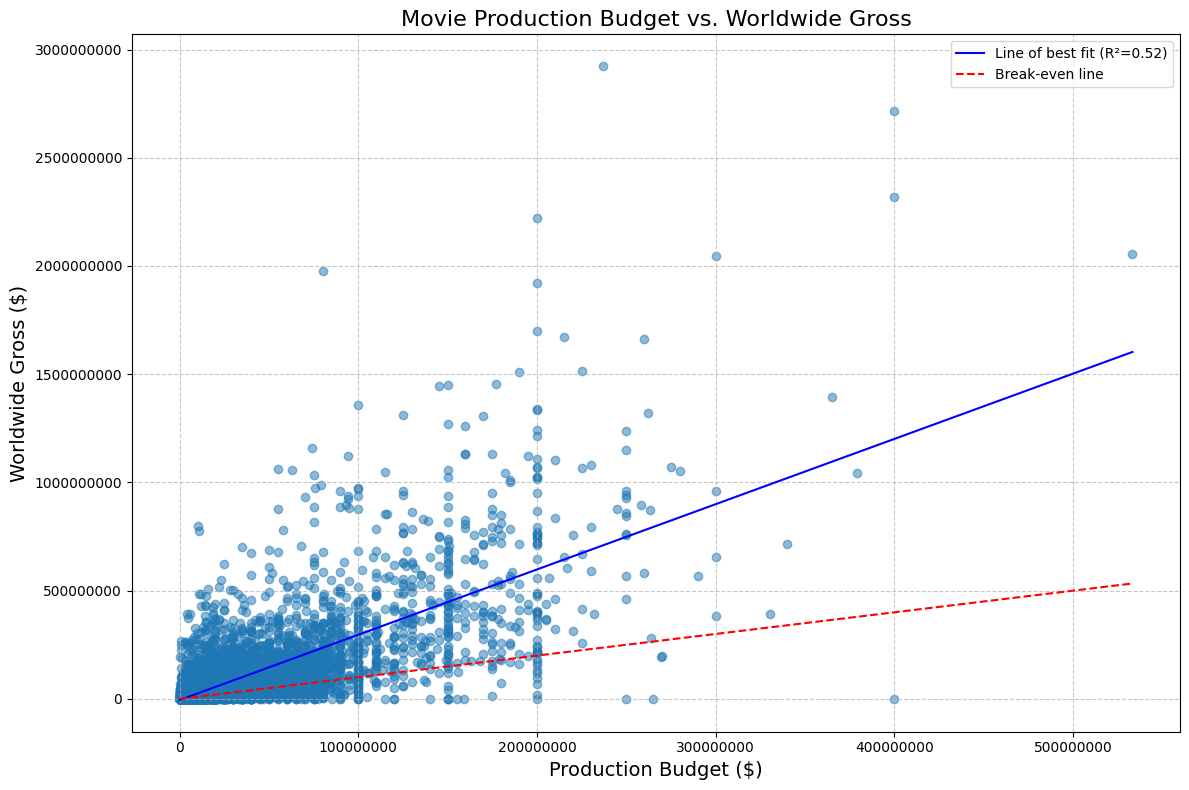

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.figure(figsize=(12, 8))

# Create scatter plot
plt.scatter(df['production_budget'], df['worldwide_gross'], alpha=0.5)

# Add line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['production_budget'], df['worldwide_gross'])
x = np.array([min(df['production_budget']), max(df['production_budget'])])
y = slope * x + intercept
plt.plot(x, y, 'b-', label=f'Line of best fit (R²={r_value**2:.2f})')

# Add break-even line
plt.plot([0, max(df['production_budget'])], [0, max(df['production_budget'])], 'r--', 
         label='Break-even line')

# Add title and labels
plt.title('Movie Production Budget vs. Worldwide Gross', fontsize=16)
plt.xlabel('Production Budget ($)', fontsize=14)
plt.ylabel('Worldwide Gross ($)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='both')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Scale the data (divide by 1 million to convert to millions)
X = df['production_budget'] / 1_000_000  # Convert to millions
X = sm.add_constant(X)
y = df['worldwide_gross'] / 1_000_000  # Convert to millions

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

# Access specific statistics
print("\nCoefficients:")
print(f"Intercept: {model.params['const']:.4f} million, p-value: {model.pvalues['const']:.4f}")
print(f"Production Budget (millions): {model.params['production_budget']:.4f}, p-value: {model.pvalues['production_budget']:.4f}")

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     6887.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:24:12   Log-Likelihood:                -40552.
No. Observations:                6429   AIC:                         8.111e+04
Df Residuals:                    6427   BIC:                         8.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.2205      2.06